### Álgebra Linear para Ciência de Dados
#### Tarefa Aula 3
**Professor:** Cassio Oishi

**Aluno:** Daniel Serezane

**Exercício**
```
Apenas para relembrar, a atividade que precisa ser resolvida é uma adaptação do eigenface. 
Será necessário criar um banco de dados de placas de carros, e gerar ruídos nelas, 
a fim de reproduzir de forma semelhante o que foi feito no caso do eigenface.
```

In [150]:
#%pip install pillow numpy opencv-python

In [151]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt
import numpy as np
import cv2 
import string
import random

Primeiro, vamos gerar o texto das placas.

O padrão de uma placa Mercosul é ``LLLNLNN`` (L = letra, N = número).

In [152]:
def gen_placa():
    letras = []
    numeros = []
    # gerando 4 letras aleatórias
    for _ in range(4):
        random_letter = random.choice(string.ascii_uppercase)
        letras.append(random_letter)
    # gerando 3 números aleatórios
    for _ in range(3):
        random_number = random.randint(0, 9)
        numeros.append(str(random_number))
    # gerando a placa LLLNLNN
    placa = ''.join(letras[:3]) + ''.join(numeros[:1]) + ''.join(letras[3:]) + ''.join(numeros[1:])
    return placa

In [153]:
n_placas = 38
n_lumi = 64

O Yale B Extended tem 38 pessoas em 64 luminosidades diferentes. Faremos 36 placas, então.

In [154]:
random.seed(666)
placas = []
# gerando 38 placas aleatórias
for _ in range(n_placas):
    placas.append(gen_placa())
print(placas)

['OMN8J08', 'RYW1K02', 'MUO3S01', 'IDJ2V24', 'UTR5N48', 'ZCJ9G02', 'UAQ0A02', 'BLY4F77', 'GOB6N58', 'IPY6D84', 'NMY1H68', 'YFN7M75', 'QOO6V52', 'KGR1L82', 'SSI4O63', 'KPU3R98', 'SWJ3Z03', 'PUC6D65', 'YJD0I04', 'ILN4S47', 'VOT7A13', 'DFZ7Z56', 'XYW4K96', 'WNN8C28', 'EMJ1C24', 'PAI7P35', 'ATW6J95', 'HIX1A52', 'OTN0N51', 'EJD7Q73', 'FAY5H23', 'DYK1L37', 'WLC7T71', 'NNF7P24', 'YYY5L33', 'EDS9V35', 'IMI8D50', 'JEP6U03']


Vamos montar a imagem.

Primeiro, carregamos o modelo.

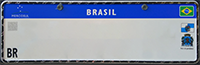

In [155]:
model = Image.open('modelo.png')
model

In [156]:
# fonte de placas automotivas
font = ImageFont.truetype("FE-FONT.TTF", 32)

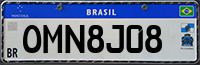

In [157]:
im_base = []
for i in range(n_placas):
    im = model.copy()
    draw = ImageDraw.Draw(im)
    # deixando espaço na direita pra letras maiores
    draw.text((22, 22), placas[i], (0,0,0),font=font)
    im_base.append(im)
im_base[0]

Ótimo! Agora precisamos apenas alterar a luminosidade.

In [158]:
# gerando um range de 64 pontos entre 0.2 e 2.5
# (obti esses valores testando)
brightvals = np.linspace(0.2, 2.5, 64)

In [159]:
datalist = []
for i in range(n_placas):
    im_lumi = []
    for j in range(n_lumi):
        im = im_base[i].copy()
        enhancer = ImageEnhance.Brightness(im)
        enhanced = enhancer.enhance(brightvals[j])
        im_lumi.append(enhanced)
    datalist.append(im_lumi)

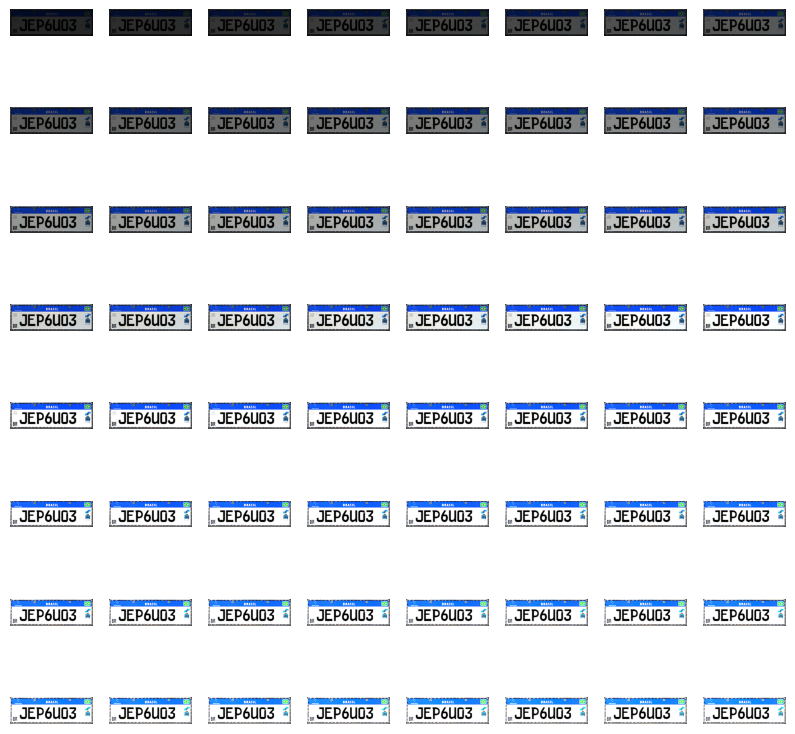

In [160]:
# plot de uma placa com diferentes níveis de brilho
plt.figure(figsize=(10,10))
for i in range(n_lumi):
    plt.subplot(8, 8, i+1)
    # usando a última, só pra variar
    plt.imshow(datalist[-1][i])
    plt.axis('off')
plt.show()

Vamos adicionar um pouco mais de ruído?

Para cada placa, sortearemos 30 das 64 imagens para receber um *motion blur*, muito comum ao tirar fotos de veículos.

A direção e intensidade do blur também será aleatória, para tentar simular a realidade.

In [161]:
max_kernel_size = 16
n_im_borrada = 30

In [162]:
random.seed(666)
np.random.seed(666)

# copy datalist
datalist_blur = datalist.copy()
for i in range(n_placas):
    # gerando 13 inteiros aleatórios entre 0 e 63
    random_ints = random.sample(range(n_lumi), n_im_borrada)
    for j in random_ints:
        im = datalist[i][j].copy()
        im_cv = np.array(im)
        # preparando o filtro -- valores aleatórios de base
        kernel_size = np.random.randint(3, max_kernel_size)
        angle = np.random.uniform(0, 360)
        # montando o kernel
        kernel = np.zeros((kernel_size, kernel_size))
        kernel[(kernel_size - 1) // 2, :] = np.ones(kernel_size)
        M = cv2.getRotationMatrix2D((kernel_size / 2 - 0.5, kernel_size / 2 - 0.5), angle, 1)
        kernel = cv2.warpAffine(kernel, M, (kernel_size, kernel_size))
        kernel = kernel / np.sum(kernel)
        blurred_im_cv = cv2.filter2D(im_cv, -1, kernel)
        blurred_im_pil = Image.fromarray(blurred_im_cv)
        # substituindo a imagem original pela borrada
        datalist_blur[i][j] = blurred_im_pil

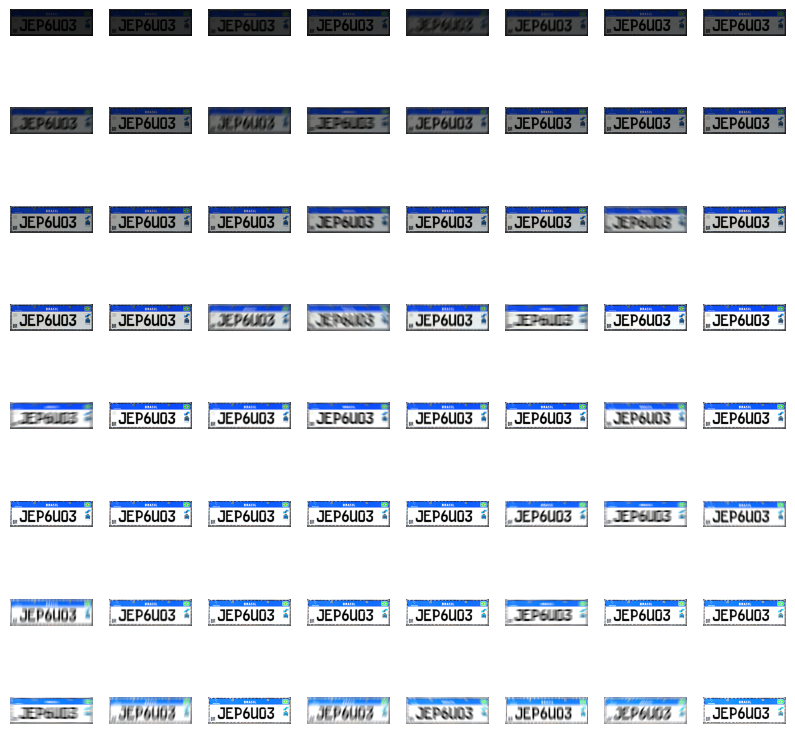

In [163]:
plt.figure(figsize=(10,10))
for i in range(n_lumi):
    plt.subplot(8,8,i+1)
    plt.imshow(datalist_blur[-1][i])
    plt.axis('off')
plt.show()

Transformand tudo em branco e preto...

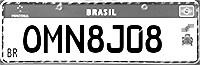

In [167]:
datalist_final = datalist_blur.copy()
for i in range(n_placas):
    for j in range(n_lumi):
        datalist_final[i][j] = datalist_final[i][j].convert('RGB')
        datalist_final[i][j] = datalist_final[i][j].convert('L')
datalist_final[0][-1]

E temos nosso dataset! Vamos apenas salvar de forma a facilitar a implementação do PCA.

O dataset Yale B tem dimensões (32256, 2410).

Ele é composto 38 rostos, dos quais são tiradas 64 fotos em diferentes luminosidades.

Cada foto tem dimensão 168 x 192.

192 x 168 = 32,256

38 x 64 = 2,432 (há algumas fotos faltando)

Cada coluna é uma imagem.
As imagens estão sequenciadas por rosto.

In [190]:
np_data = np.zeros((model.size[0] * model.size[1], n_placas * n_lumi), dtype=np.uint8)
print(np_data.shape)
for i in range(n_placas):
    placa_range = range(i * n_lumi, (i + 1) * n_lumi)
    for j, jj in zip(range(n_lumi), placa_range):
        np_data[:, jj] = np.array(datalist_final[i][j]).flatten()

(13000, 2432)


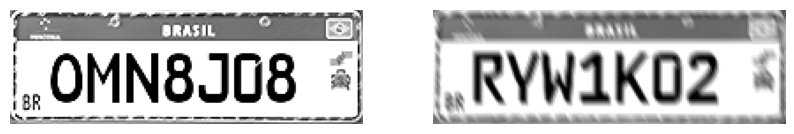

In [191]:
# pegando a imagem 63 e 120 pra testar
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(np_data[:, 63].reshape(model.size[1], model.size[0]), cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np_data[:, 120].reshape(model.size[1], model.size[0]), cmap='gray')
plt.axis('off')
plt.show()

In [192]:
placas[0], placas[1]

('OMN8J08', 'RYW1K02')

In [193]:
np_data

array([[ 18,  15,  19, ..., 152, 144, 178],
       [ 18,  14,  17, ..., 128, 142, 161],
       [ 19,  13,  14, ..., 151, 147, 132],
       ...,
       [ 18,   9,  11, ..., 144, 154, 101],
       [ 13,   9,  11, ..., 139, 121, 101],
       [  9,   9,  13, ..., 110, 122, 124]], dtype=uint8)

In [194]:
# salvando nosso dataset
np.save('placas.npy', np_data)